# Klimadaten analysieren mit Python

Zunächst werden die für dieses Jupyter Notebook benötigten Libraries geladen:

In [1]:
#Benötigte Libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# MatplotLib Settings:
plt.style.use('default') # Matplotlib Style wählen
plt.figure(figsize=(10,5)) # Plot-Größe
plt.rcParams['font.size'] = 10; # Schriftgröße

<Figure size 1000x500 with 0 Axes>

## Daten einlesen als 'DataFrame'

Im Folgenden Nutzen wir globale Klimadaten, die auf der Webseite der NASA zu finden sind: https://data.giss.nasa.gov/gistemp/. Hierbei handelt es sich um Temperaturdaten, die Anomalien gegenüber dem Mittelwert in den Jahren 1951-1980 aufweisen.
Es werden Daten von Dateien (online oder offline) eingelesen mit der Python Bilbiothek `pandas`. Die Daten werden in sogenannten *DataFrames* hier mit dem Namen `global_mean` abgespeichert. 

In [2]:
#link = "https://data.giss.nasa.gov/gistemp/graphs_v4/graph_data/Global_Mean_Estimates_based_on_Land_and_Ocean_Data/graph.csv"
link = 'data/graph.csv'
global_mean = pd.read_csv(link, header = 1) 

Wir geben das *DataFrame* aus um uns die Messdaten einmal anzusehen: 

In [3]:
global_mean.head(6) # Ausgabe der ersten 5 Spalten
#global_mean.tail(5) # Ausgabe der letzten 5 Spalten
#global_mean # Ausgabe des DataFrames 

,Year,No_Smoothing,Lowess(5)
0,1880,-0.17,-0.09
1,1881,-0.08,-0.13
2,1882,-0.11,-0.17
3,1883,-0.18,-0.20
4,1884,-0.28,-0.24
5,1885,-0.33,-0.26


In der ersten Spalte befinden sich lediglich die Indizes der Messungen. Die zweite Spalte beinhaltet das Jahr und die dritte Spalte zeigt den gemessenen globalen Temperaturunterschied im Vergleich zur gemittelten Temeratur der Jahre 1951-1980. Die letzte Spalte zeigt die gleichen Messwerte, jedoch gefiltert. 

Einzelne Spalten kann man sich anzeigen lassen, indem den Spaltel-Namen des zugehörigen *DataFrames* nutzt:

In [4]:
global_mean['Year']

0      1880
1      1881
2      1882
3      1883
4      1884
       ... 
137    2017
138    2018
139    2019
140    2020
141    2021
Name: Year, Length: 142, dtype: int64

## Daten plotten mit 'matplotlib'

Als Beispiel für eine gelungene grafische Darstellung wollen wir die beiden Spalten, *No_Smoothing* and *Lowess(5)* gegenüber der Zeitachse *Year* plotten. Hierfür benützen wir die Python Library `matplotlib`:

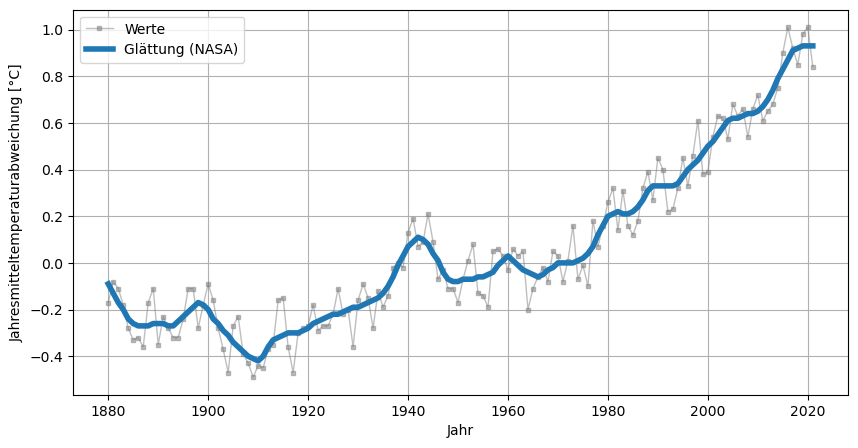

In [5]:
import matplotlib.pyplot as plt
plt.style.use('default')
plt.figure(figsize=(10,5))
plt.rcParams['font.size'] = 10;
plt.plot(global_mean["Year"],global_mean["No_Smoothing"], ls="-", lw=1, marker="s", ms=3, color="tab:gray", alpha=0.5, label="Werte");
plt.plot(global_mean["Year"],global_mean["Lowess(5)"], lw=4,  color="tab:blue", label="Glättung (NASA)");
plt.xlabel('Jahr')
plt.ylabel("Jahresmitteltemperaturabweichung [°C]")
plt.legend();
plt.grid();

## Messunsicherheiten als Fehlerbalken hinzufügen

Bei diesem Datenset stehen uns leider keine Messunsicherheiten zur Verfügung. Um Sie jedoch als Fehlerbalken miteinzubeziehen, wollen wir im Folgenden annehmen, dass der Temperaturunterschied auf 0.25K genau messen werden konnte und fügen die unserem Datensatz hinzu:

In [6]:
global_mean["uncertainty"] = 0.25
print(global_mean)

     Year  No_Smoothing  Lowess(5)  uncertainty
0    1880         -0.17      -0.09         0.25
1    1881         -0.08      -0.13         0.25
2    1882         -0.11      -0.17         0.25
3    1883         -0.18      -0.20         0.25
4    1884         -0.28      -0.24         0.25
..    ...           ...        ...          ...
137  2017          0.92       0.91         0.25
138  2018          0.85       0.92         0.25
139  2019          0.98       0.93         0.25
140  2020          1.01       0.93         0.25
141  2021          0.84       0.93         0.25

[142 rows x 4 columns]


Grafisch darstellen tun wir Messunsicherheiten mittels Fehlerbalken und der Matplotlib-Funktion `plt.errorbar`. 

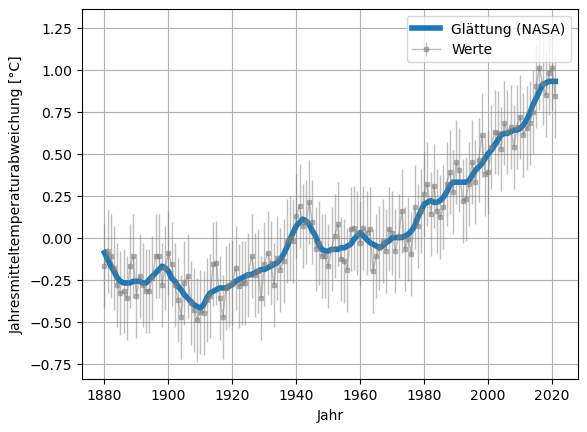

In [7]:
plt.errorbar(global_mean["Year"],global_mean["No_Smoothing"], yerr=global_mean["uncertainty"], ls="-", lw=1, marker="s", ms=3, color="tab:gray", alpha=0.5, label="Werte");
plt.plot(global_mean["Year"],global_mean["Lowess(5)"], lw=4,  color="tab:blue", label="Glättung (NASA)");
plt.xlabel('Jahr')
plt.ylabel("Jahresmitteltemperaturabweichung [°C]")
plt.legend();
plt.grid();

## Ausgleichsgerade berechnen und plotten

Mittels linearer Regression kann der Temperaturanstieg aus den Daten berechnet werden. Hierfür wird die Python Library `numpy` benutzt und die Funktion `polyfit` aufgerufen und in als `model` gespeichert. Diese Funktion benutzt die Least-Square Methode für polynomische Modelle. Weitere Informationen zu der Funktion findet ihr [hier](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html). Mit der Option `cov=True` wird die Kovarianz-Matrix berechnet, welche die Unsicherheiten für die Fit-Parameter beinhaltet. 

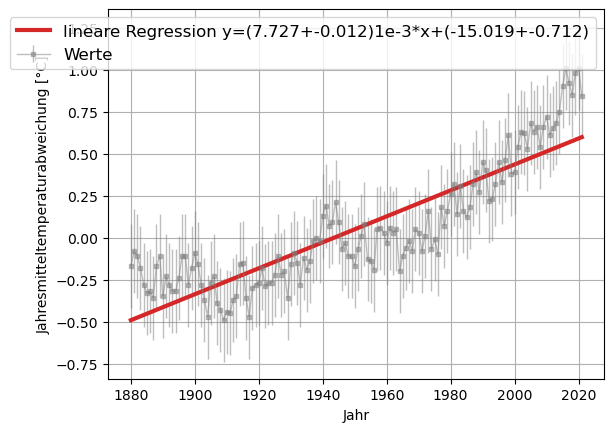

In [8]:
import numpy as np
import pandas as pd

x=global_mean["Year"]
y=global_mean["No_Smoothing"]
y_err = global_mean["uncertainty"]
model = np.polyfit(x, y, deg=1, w=1/y_err, cov=True) # 1. Wert = Anstieg , 2. Wert = Schnittpunkt mit y-Achse
y_model = model[0][0]*x+model[0][1] # Modell einer linearen Regression

plt.ylabel("Jahresmitteltemperaturabweichung [°C]")
plt.xlabel("Jahr")
plt.errorbar(global_mean["Year"],global_mean["No_Smoothing"], yerr=global_mean["uncertainty"], ls="-", lw=1, marker="s", ms=3, color="tab:gray", alpha=0.5, label="Werte");
plt.plot(x,y_model, ls="-", lw=3, color="tab:red", label=f"lineare Regression y=({model[0][0]*1000:.3f}+-{np.sqrt(model[1][0][0]*1000):.3f})1e-3*x+({model[0][1]:.3f}+-{np.sqrt(model[1][1][1]):.3f})");
plt.legend(fontsize=12);
plt.grid();

Das Model beinhaltet zwei Matrizen:

In [9]:
model

(array([ 7.72740894e-03, -1.50191421e+01]),
 array([[ 1.33257719e-07, -2.59919181e-04],
        [-2.59919181e-04,  5.07196269e-01]]))

Im ersten Array stehen die Fit-Parameter der linearen Ausgleichsgeraden entsprechend der obigen Deklaration: `y_model = model[0][0]*x+model[0][1]`.
Im zweiten Array, hier eine 2x2 Matrix, sind die Unsicherheiten in Form von der Kovarianz-Matrix dargestellt. Auf der Diagonalen stehen die Varianzen, $s^2$, auf den Nicht-Diagonalelementen stehen die Kovarianzen (Korrelationsterme zwischen $m$ und $b$):

$$\mathrm{cov}(m,b) = 
\begin{pmatrix}
 s_m^2 & s_{mb} \\
 s_{bm} & s_b^2
\end{pmatrix} $$

Der Temperaturanstieg kann entsprechend ausgegeben werden:

In [10]:
print(f"Temperaturanstieg pro Jahr (von 1981 bis 2020): {model[0][0]:.3f}°C/Jahr")
print(f"Temperaturanstieg seit Beginn der Messung: {(y_model.iloc[-1]-y_model.iloc[0]):.3f}°C")

Temperaturanstieg pro Jahr (von 1981 bis 2020): 0.008°C/Jahr
Temperaturanstieg seit Beginn der Messung: 1.090°C


```{warning}
Die lineare Regression bezieht hier den ganzen Zeitraum mit ein! Im folgenden betrachten wir für den Temperaturgradienten nur die Daten von 1980 bis 2020!
```

In [11]:
x=global_mean.loc[global_mean["Year"] >= 1980,"Year"]
y=global_mean.loc[global_mean["Year"] >= 1980,"No_Smoothing"]
y_err = global_mean.loc[global_mean["Year"] >= 1980,"uncertainty"]

model = np.polyfit(x, y, deg=1, w=1/y_err, cov=True) # 1. Wert = Anstieg , 2. Wert = Schnittpunkt mit y-Achse
y_model = model[0][0]*x+model[0][1] # Modell einer linearen Regression
print(f"Temperaturanstieg pro Jahr (von 1980 bis 2020): {model[0][0]:.3f}°C/Jahr")

Temperaturanstieg pro Jahr (von 1980 bis 2020): 0.019°C/Jahr


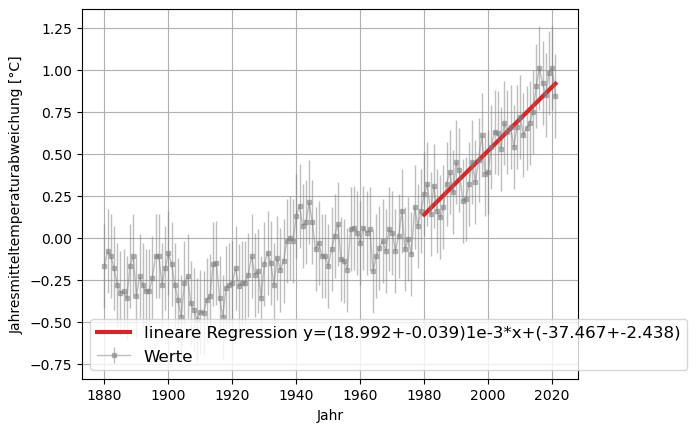

In [12]:
plt.ylabel("Jahresmitteltemperaturabweichung [°C]")
plt.xlabel("Jahr")
plt.errorbar(global_mean["Year"],global_mean["No_Smoothing"], yerr=global_mean["uncertainty"], ls="-", lw=1, marker="s", ms=3, color="tab:gray", alpha=0.5, label="Werte");
plt.plot(x,y_model, ls="-", lw=3, color="tab:red", label=f"lineare Regression y=({model[0][0]*1000:.3f}+-{np.sqrt(model[1][0][0]*1000):.3f})1e-3*x+({model[0][1]:.3f}+-{np.sqrt(model[1][1][1]):.3f})");
plt.legend(fontsize=12);
plt.grid();